In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar (ilk kez yapıyorsan aktif et)
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt ="savasy/bert-base-turkish-sentiment-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) /
        (cm.sum() - cm[i].sum()) if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
# ✅ Eğitim ayarları (DÜZENLENMİŞ)
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert_model_best_28",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,                      # ✅ makul bir değer
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,                     # ✅ makul, erken durdurma var zaten
    weight_decay=0.01,
    warmup_ratio=0.1,
    label_smoothing_factor=0.05,             # bırakılabilir
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer (değişiklik yok)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

RuntimeError: Error(s) in loading state_dict for Linear:
	size mismatch for bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([5]).

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at savasy/bert-base-turkish-sentiment-cased and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-3972036230.py:124: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,0.850600,0.427396,0.915092,0.916552,0.915093,0.915413,0.915093,0.978774,0.987879
2,0.409100,0.380067,0.941209,0.941637,0.941206,0.941341,0.941206,0.985302,0.991883
3,0.347900,0.344707,0.958213,0.958158,0.958209,0.958083,0.958209,0.989553,0.993724
4,0.302000,0.322510,0.969438,0.969556,0.969436,0.969462,0.969436,0.992360,0.993660
5,0.277800,0.317904,0.972327,0.972563,0.972328,0.972343,0.972328,0.993082,0.993498
6,0.267300,0.306955,0.976550,0.976559,0.976549,0.976526,0.976549,0.994138,0.993850
7,0.252200,0.298756,0.979996,0.980123,0.979996,0.980002,0.979996,0.994999,0.993702
8,0.245600,0.298944,0.979996,0.980022,0.979995,0.980003,0.979995,0.994999,0.994671
9,0.243700,0.295814,0.980551,0.980560,0.980550,0.980544,0.980550,0.995138,0.994892
10,0.241000,0.296427,0.980329,0.980312,0.980328,0.980305,0.980328,0.995082,0.993823



✅ Model Performansı:
accuracy: 0.9854
precision: 0.9855
recall: 0.9854
f1: 0.9855
sensitivity: 0.9854
specificity: 0.9964
auc_macro: 0.9959
🕒 Eğitim süresi: 6891.53 sn
🕒 Inference süresi: 31.83 sn


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


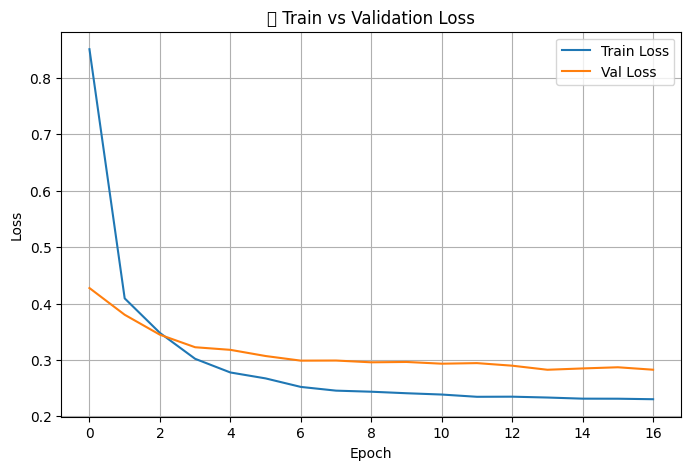

/tmp/ipython-input-2-3972036230.py:178: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


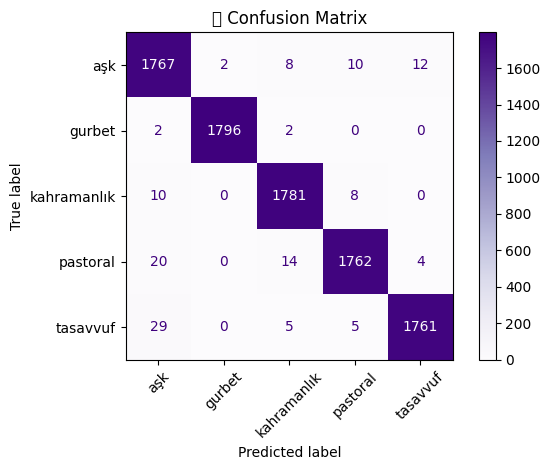

/tmp/ipython-input-2-3972036230.py:200: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


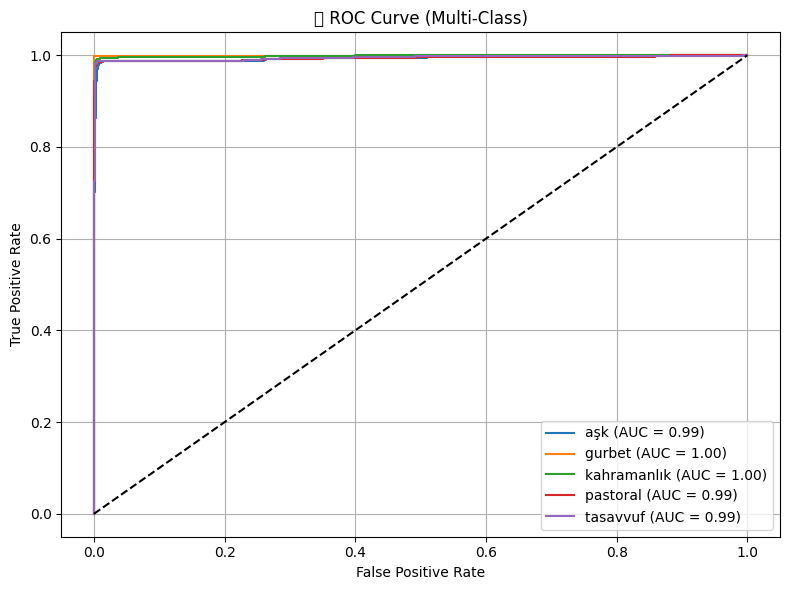

In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "savasy/bert-base-turkish-sentiment-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    config=config,
    ignore_mismatched_sizes=True  # 🔑 Hata burada çözülüyor
)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) / (cm.sum() - cm[i].sum())
        if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert_model_best_28",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.1,
    label_smoothing_factor=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Map:   0%|          | 0/35990 [00:00<?, ? examples/s]

Map:   0%|          | 0/8998 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at savasy/bert-base-turkish-sentiment-cased and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3-2379588088.py:124: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,Auc Macro
1,1.166900,0.548467,0.868971,0.870101,0.868967,0.869354,0.868967,0.967243,0.972745
2,0.472000,0.425070,0.917982,0.918625,0.917979,0.918212,0.917979,0.979496,0.987534
3,0.406500,0.393545,0.932763,0.933832,0.932762,0.933061,0.932762,0.983191,0.990585
4,0.368200,0.365548,0.950545,0.950835,0.950542,0.950646,0.950542,0.987636,0.992403
5,0.331300,0.344782,0.957991,0.958225,0.957990,0.958051,0.957990,0.989498,0.992441
6,0.297800,0.326507,0.965103,0.965109,0.965100,0.965038,0.965100,0.991276,0.993570
7,0.272900,0.331674,0.966659,0.966891,0.966655,0.966513,0.966655,0.991665,0.992552
8,0.257400,0.301012,0.976550,0.976564,0.976549,0.976551,0.976549,0.994138,0.994611
9,0.245500,0.294519,0.979106,0.979133,0.979105,0.979114,0.979105,0.994777,0.993465
10,0.239700,0.294954,0.979551,0.979573,0.979550,0.979546,0.979550,0.994888,0.992841



✅ Model Performansı:
accuracy: 0.9841
precision: 0.9841
recall: 0.9841
f1: 0.9841
sensitivity: 0.9841
specificity: 0.9960
auc_macro: 0.9935
🕒 Eğitim süresi: 7090.57 sn
🕒 Inference süresi: 33.38 sn


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


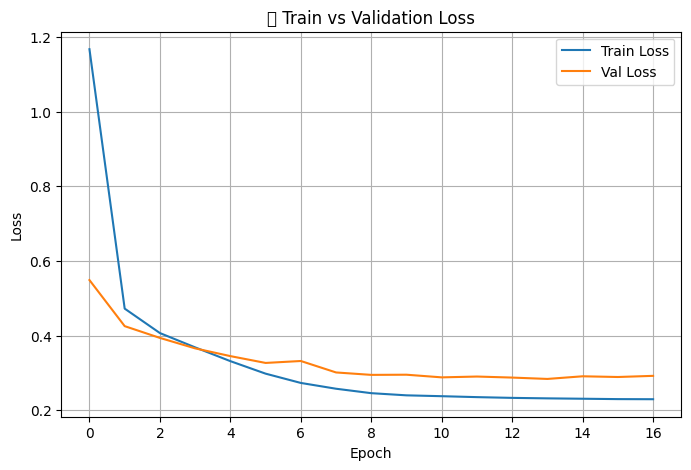

/tmp/ipython-input-3-2379588088.py:178: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


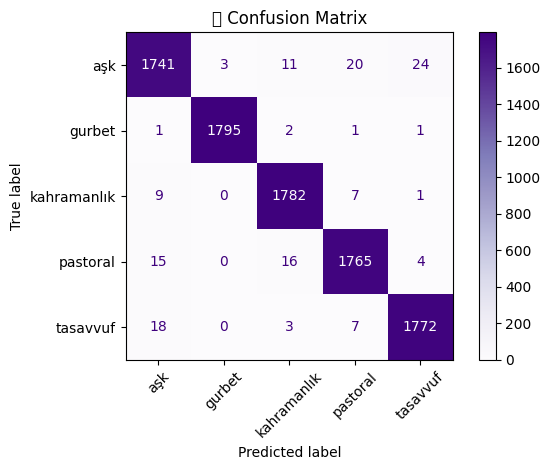

/tmp/ipython-input-3-2379588088.py:200: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


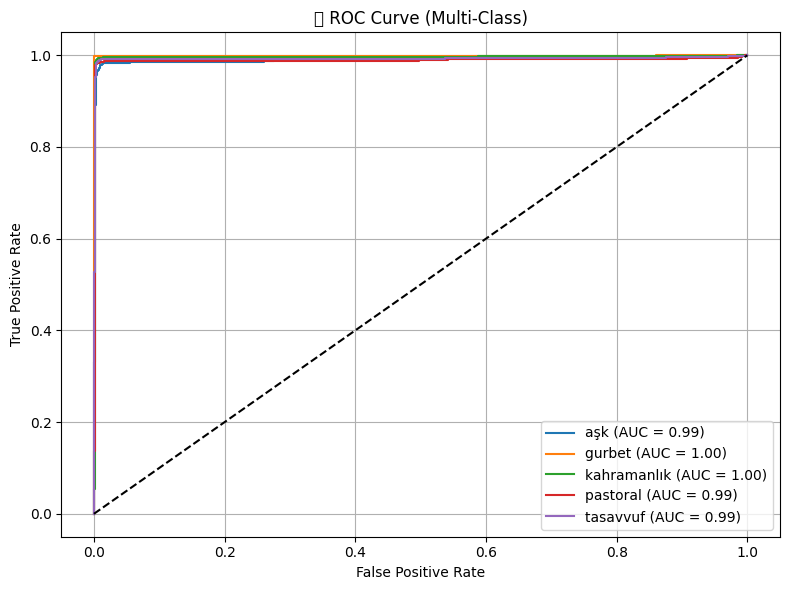

In [ ]:
# ✅ Ortamı hazırla
import os
os.environ["WANDB_DISABLED"] = "true"

from google.colab import drive
drive.mount('/content/drive')

# ✅ Gerekli Kurulumlar
!pip install transformers datasets scikit-learn evaluate matplotlib seaborn joblib --quiet

# ✅ Kütüphaneler
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoConfig, TrainingArguments, Trainer, DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

# ✅ Veri yolları
train_path = "/content/drive/MyDrive/augmented_train_80_20.json"
val_path = "/content/drive/MyDrive/augmented_val_80_20.json"

with open(train_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(val_path, "r", encoding="utf-8") as f:
    val_data = json.load(f)

# ✅ Dataset'e çevir
train_ds = Dataset.from_list(train_data)
val_ds = Dataset.from_list(val_data)

# ✅ Label encode
etiketler = sorted(set(x["konu"] for x in train_data))
etiket2id = {etiket: i for i, etiket in enumerate(etiketler)}
id2etiket = {v: k for k, v in etiket2id.items()}

train_ds = train_ds.map(lambda x: {"label": etiket2id[x["konu"]]})
val_ds = val_ds.map(lambda x: {"label": etiket2id[x["konu"]]})

# ✅ Tokenizer
model_ckpt = "savasy/bert-base-turkish-sentiment-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# ✅ Tokenizasyon
def tokenize(batch):
    return tokenizer(batch["islenmis_siir"], truncation=True, padding="max_length", max_length=256)

train_ds = train_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["islenmis_siir", "konu"])

# ✅ Model + Dropout ayarı
config = AutoConfig.from_pretrained(
    model_ckpt,
    num_labels=len(etiketler),
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    config=config,
    ignore_mismatched_sizes=True  # 🔑 Hata burada çözülüyor
)

# ✅ Değerlendirme metrikleri
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    cm = confusion_matrix(y_true, y_pred)
    sensitivity = np.mean([cm[i, i] / cm[i].sum() if cm[i].sum() != 0 else 0 for i in range(len(cm))])
    specificity = np.mean([
        (cm.sum() - cm[i].sum() - cm[:, i].sum() + cm[i, i]) / (cm.sum() - cm[i].sum())
        if (cm.sum() - cm[i].sum()) != 0 else 0
        for i in range(len(cm))
    ])
    auc_macro = roc_auc_score(label_binarize(y_true, classes=range(len(etiketler))),
                              pred.predictions, average='macro', multi_class='ovr')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc_macro": auc_macro
    }

# ✅ Eğitim ayarları
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert_model_best_28",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    warmup_ratio=0.1,
    label_smoothing_factor=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    seed=42,
    report_to=[]
)

# ✅ Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ✅ Eğitim başlat
start = time.time()
trainer.train()
train_time = time.time() - start

# ✅ Tahmin ve değerlendirme
start = time.time()
preds = trainer.predict(val_ds)
infer_time = time.time() - start
metrics = compute_metrics(preds)

print("\n✅ Model Performansı:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"🕒 Eğitim süresi: {train_time:.2f} sn")
print(f"🕒 Inference süresi: {infer_time:.2f} sn")

# ✅ Kayıp Grafiği
logs = trainer.state.log_history
train_loss = [l["loss"] for l in logs if "loss" in l]
eval_loss = [l["eval_loss"] for l in logs if "eval_loss" in l]

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("📉 Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Confusion Matrix
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=[id2etiket[i] for i in range(len(etiketler))],
    cmap="Purples", xticks_rotation=45
)
plt.title("📌 Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# ✅ ROC Eğrisi
y_true_bin = label_binarize(y_true, classes=list(range(len(etiketler))))
y_score = preds.predictions

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(etiketler)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(etiketler)):
    plt.plot(fpr[i], tpr[i], label=f"{id2etiket[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.title("📈 ROC Curve (Multi-Class)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
